# Shear instability of a free-surface flow

This script simulates the instability of a sheared, free-surface
flow using `ClimateMachine.Ocean.HydrostaticBoussinesqSuperModel`.

In [1]:
using Printf
using Plots
using ClimateMachine

ClimateMachine.init()

ClimateMachine.Settings.array_type = Array

using ClimateMachine.Ocean
using ClimateMachine.Ocean.Domains
using ClimateMachine.Ocean.Fields

using ClimateMachine.GenericCallbacks: EveryXSimulationTime
using ClimateMachine.Ocean: current_step, Δt, current_time
using CLIMAParameters: AbstractEarthParameterSet, Planet

We begin by specifying the domain and mesh,

In [2]:
domain = RectangularDomain(
    Ne = (24, 24, 1),
    Np = 4,
    x = (-3π, 3π),
    y = (-3π, 3π),
    z = (0, 1),
    periodicity = (true, false, false),
)

RectangularDomain{Float64}
    Np = 4, Ne = (x = 24, y = 24, z = 1)
    L = (x = 18.84955592153876, y = 18.84955592153876, z = 1.0)


Note that the default solid-wall boundary conditions are free-slip and
insulating on tracers. Next, we specify model parameters and the sheared
initial conditions

In [3]:
struct NonDimensionalParameters <: AbstractEarthParameterSet end
Planet.grav(::NonDimensionalParameters) = 1

initial_conditions = InitialConditions(
    u = (x, y, z) -> tanh(y) + 0.1 * cos(x / 3) + 0.01 * randn(),
    v = (x, y, z) -> 0.1 * sin(y / 3),
    θ = (x, y, z) -> x,
)

model = Ocean.HydrostaticBoussinesqSuperModel(
    domain = domain,
    time_step = 0.05,
    initial_conditions = initial_conditions,
    parameters = NonDimensionalParameters(),
    turbulence_closure = (νʰ = 1e-2, κʰ = 1e-2, νᶻ = 1e-2, κᶻ = 1e-2),
    rusanov_wave_speeds = (cʰ = 0.1, cᶻ = 1),
    boundary_tags = ((0, 0), (1, 1), (1, 2)),
    boundary_conditions = (
        OceanBC(Impenetrable(FreeSlip()), Insulating()),
        OceanBC(Penetrable(FreeSlip()), Insulating()),
    ),
)

┌ Info: Initializing 
└ @ ClimateMachine /central/scratch/climaci/climatemachine-docs/892/climatemachine-docs/src/Driver/solver_configs.jl:167


ClimateMachine.Ocean.SuperModels.HydrostaticBoussinesqSuperModel{ClimateMachine.Ocean.Domains.RectangularDomain{Float64},ClimateMachine.Mesh.Grids.DiscontinuousSpectralElementGrid{Float64,3,(4, 4, 4),125,Array,Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1}},Tuple{Array{Float64,2},Array{Float64,2},Array{Float64,2}},Array{Float64,3},Array{Float64,4},Array{Int64,1},Array{Int64,2},Array{Int64,3},ClimateMachine.Mesh.Topologies.StackedBrickTopology{3,Float64,2},Tuple{Array{Float64,2},Array{Float64,2},Array{Float64,2}},ClimateMachine.Mesh.Grids.MinNodalDistance{Float64}},ClimateMachine.Ocean.HydrostaticBoussinesq.HydrostaticBoussinesqModel{ClimateMachine.Ocean.Uncoupled,Main.##365.NonDimensionalParameters,ClimateMachine.Ocean.OceanProblems.InitialValueProblem{Float64,ClimateMachine.Ocean.OceanProblems.InitialConditions{Main.##365.var"#1#4",Main.##365.var"#2#5",Main.##365.var"#3#6",typeof(ClimateMachine.Ocean.OceanProblems.resting)},Tuple{ClimateMachine.Ocean.OceanBC{ClimateMachine.O

We prepare a callback that periodically fetches the horizontal velocity and
tracer concentration for later animation,

In [4]:
u, v, η, θ = model.fields
fetched_states = []

start_time = time_ns()

data_fetcher = EveryXSimulationTime(1) do
    step = @sprintf("Step: %d", current_step(model))
    time = @sprintf("time: %.2f min", current_time(model) / 60)
    max_u = @sprintf("max|u|: %.6f", maximum(abs, u))

    elapsed = (time_ns() - start_time) * 1e-9
    wall_time = @sprintf("elapsed wall time: %.2f min", elapsed / 60)

    @info "$step, $time, $max_u, $wall_time"

    push!(
        fetched_states,
        (u = assemble(u), θ = assemble(θ), time = current_time(model)),
    )
end

ClimateMachine.GenericCallbacks.EveryXSimulationTime(Main.##365.var"#7#8"(), 1, 0)

and then run the simulation.

In [5]:
model.solver_configuration.timeend = 100.0

result = ClimateMachine.invoke!(
    model.solver_configuration;
    user_callbacks = [data_fetcher],
)

┌ Info: Starting 
│     dt              = 5.00000e-02
│     timeend         =   100.00
│     number of steps = 1
│     norm(Q)         = 1.0412196186830819e+02
└ @ ClimateMachine /central/scratch/climaci/climatemachine-docs/892/climatemachine-docs/src/Driver/Driver.jl:763
┌ Info: Step: 20, time: 0.02 min, max|u|: 1.105455, elapsed wall time: 0.78 min
└ @ Main.##365 string:14
┌ Info: Step: 40, time: 0.03 min, max|u|: 1.084746, elapsed wall time: 0.85 min
└ @ Main.##365 string:14
┌ Info: Step: 61, time: 0.05 min, max|u|: 1.061249, elapsed wall time: 0.90 min
└ @ Main.##365 string:14
┌ Info: Step: 82, time: 0.07 min, max|u|: 1.051660, elapsed wall time: 0.94 min
└ @ Main.##365 string:14
┌ Info: Step: 103, time: 0.09 min, max|u|: 1.061375, elapsed wall time: 0.98 min
└ @ Main.##365 string:14
┌ Info: Update
│     simtime =     6.05 /   100.00
│     wallclock = 00:01:00
│     efficiency (simtime / wallclock) =   0.1001
│     wallclock end (estimated) = 00:16:38
│     norm(Q) = 9.650019674225

0.543863019180897

Finally, we make an animation of the evolving shear instability.

┌ Info: Plotting frame 1 of 96...
└ @ Main.##365 string:5
┌ Info: Plotting frame 2 of 96...
└ @ Main.##365 string:5
┌ Info: Plotting frame 3 of 96...
└ @ Main.##365 string:5
┌ Info: Plotting frame 4 of 96...
└ @ Main.##365 string:5
┌ Info: Plotting frame 5 of 96...
└ @ Main.##365 string:5
┌ Info: Plotting frame 6 of 96...
└ @ Main.##365 string:5
┌ Info: Plotting frame 7 of 96...
└ @ Main.##365 string:5
┌ Info: Plotting frame 8 of 96...
└ @ Main.##365 string:5
┌ Info: Plotting frame 9 of 96...
└ @ Main.##365 string:5
┌ Info: Plotting frame 10 of 96...
└ @ Main.##365 string:5
┌ Info: Plotting frame 11 of 96...
└ @ Main.##365 string:5
┌ Info: Plotting frame 12 of 96...
└ @ Main.##365 string:5
┌ Info: Plotting frame 13 of 96...
└ @ Main.##365 string:5
┌ Info: Plotting frame 14 of 96...
└ @ Main.##365 string:5
┌ Info: Plotting frame 15 of 96...
└ @ Main.##365 string:5
┌ Info: Plotting frame 16 of 96...
└ @ Main.##365 string:5
┌ Info: Plotting frame 17 of 96...
└ @ Main.##365 string:5
┌ Info

Plots.AnimatedGif("/central/scratch/climaci/climatemachine-docs/892/climatemachine-docs/docs/src/generated/Ocean/shear_instability.gif")
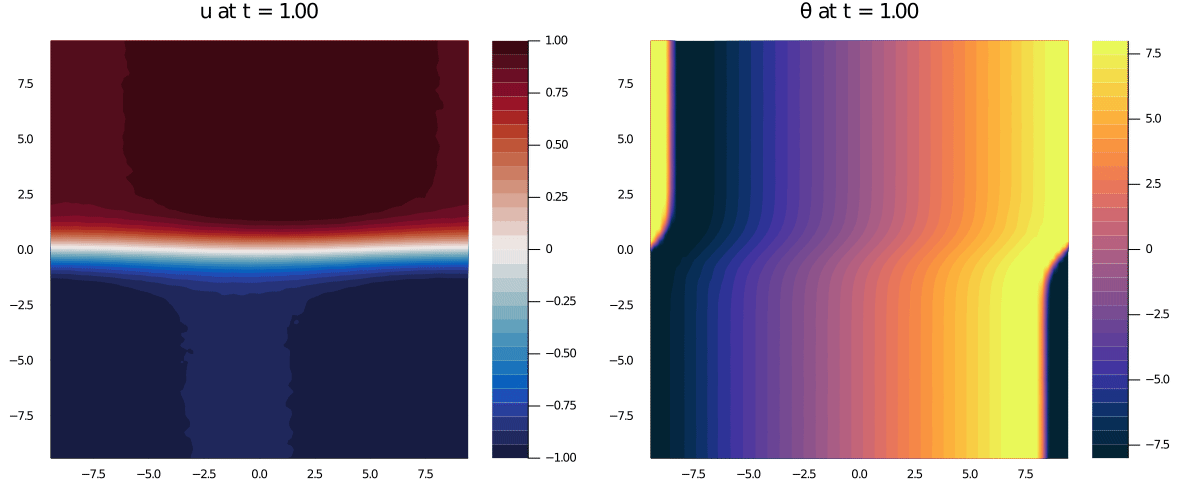

In [6]:
animation = @animate for (i, state) in enumerate(fetched_states)
    local u
    local θ

    @info "Plotting frame $i of $(length(fetched_states))..."

    kwargs =
        (xlim = domain.x, ylim = domain.y, linewidth = 0, aspectratio = 1)

    x, y = state.u.x[:, 1, 1], state.u.y[1, :, 1]

    u = state.u.data[:, :, 1]
    θ = state.θ.data[:, :, 1]

    ulim = 1
    θlim = 8

    ulevels = range(-ulim, ulim, length = 31)
    θlevels = range(-θlim, θlim, length = 31)

    u_plot = contourf(
        x,
        y,
        clamp.(u, -ulim, ulim)';
        levels = ulevels,
        color = :balance,
        kwargs...,
    )
    θ_plot = contourf(
        x,
        y,
        clamp.(θ, -θlim, θlim)';
        levels = θlevels,
        color = :thermal,
        kwargs...,
    )

    u_title = @sprintf("u at t = %.2f", state.time)
    θ_title = @sprintf("θ at t = %.2f", state.time)

    plot(u_plot, θ_plot, title = [u_title θ_title], size = (1200, 500))
end

gif(animation, "shear_instability.gif", fps = 8)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*